<img src=https://storage.googleapis.com/kaggle-datasets-images/180/384/3da2510581f9d3b902307ff8d06fe327/dataset-cover.jpg>  
## Breast Cancer Wisconsin (Diagnostic) Data Set
[Kaggle Data set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data#data.csv): Predict whether the cancer is benign or malignant

In [138]:
import numpy as np
import pandas as pd
import featuretools as ft  # featuretools for automated feature engineering
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from featuretools import selection
from warnings import simplefilter  # import warnings filter

pd.options.mode.chained_assignment = None  #hide any pandas warnings
simplefilter(action='ignore', category=FutureWarning)  # ignore all future warnings
np.random.seed(123) #ensure reproducibility
%matplotlib inline

### Section (1) : Data Preparation

#### 1. Download dataset from [Kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/data.csv/2)

In [139]:
# Read breast cancer data set as Pandas dataframe
df_raw = pd.read_csv("data.csv")
df_raw.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### 2. Clean up dataframe

In [140]:
# rearrange columns; remove coluum "Unnamed: 32"; set id as index
fixed_columns = [df_raw.columns[0]]+list(df_raw.columns[2:-1])+[df_raw.columns[1]]
df_data = df_raw[fixed_columns]

In [141]:
# Convert (M=malignant, B=benign) to (1,0)
df_data.loc[df_data.index[df_data['diagnosis']=='B'],'diagnosis'] = 0
df_data.loc[df_data.index[df_data['diagnosis']=='M'],'diagnosis'] = 1

In [142]:
df_data.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


#### Column Description
diagnosis: The diagnosis of breast tissues (M = malignant, B = benign)  
radius: Distances from center to points on the perimeter  
texture: Standard deviation of gray-scale values  
perimeter: Mean size of the core tumor  
smoothness: Local variation in radius lengths  
compactness: perimeter^2 / area - 1.0  
concavity: Sverity of concave portions of the contour  
concave points: Number of concave portions of the contour   
fractal_dimension: "coastline approximation" - 1  

#### 3. Count the case number of benign and malignant

[Text(0, 0, 'benign'), Text(0, 0, 'malignant')]

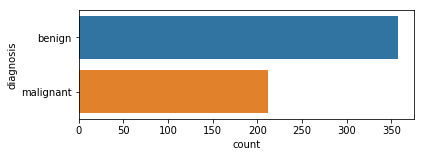

In [143]:
plt.figure(figsize=(6,2))
ax = sns.countplot(y='diagnosis', data=df_data)
ax.set_yticklabels(['benign','malignant'])

In [144]:
df_data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.372583
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,0.000000
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


### Section (2) : Compare the Performance of Machine Leanring Models

#### 1. Setup function for K-fold cross validation

In [145]:
def cross_validatoin(fold, model, X, y):
    """
    Perform K-fold cross validation
    compare the sensitivity, specificity, accuracy, and F1-score of input models
    """
    sensitivity=[]
    specificity=[]
    accuracy=[]
    F1scores=[]
    
    kf = KFold(n_splits=fold,shuffle=True) 
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test,y_pred)
        sensitivity.append(cm[0,0]/(cm[0,0]+cm[1,0]))
        specificity.append(cm[1,1]/(cm[1,1]+cm[0,1]))
        accuracy.append(accuracy_score(y_test,y_pred))
        F1scores.append(f1_score(y_test, y_pred, pos_label=1))
        
    return [np.mean(sensitivity),np.mean(specificity),np.mean(accuracy),np.mean(F1scores)]

In [146]:
# Set the number of fold for cross validation
fold = 10

#### 2. Apply and compare machine learning models

In [147]:
# Prepare input matrix for machine learning models
feature_names = df_data.columns.tolist()[1:-1]
X = df_data[feature_names].values
y = df_data['diagnosis'].values

In [148]:
# Create dictionary to collect results
d_Model_eva = {} 

# Logistic regression
d_Model_eva['Logistic Regression'] = cross_validatoin(fold, LogisticRegression(), X, y)

# Decision tree
d_Model_eva['Decision Tree'] = cross_validatoin(fold, DecisionTreeClassifier(), X, y)

# Random forest
d_Model_eva['Random Forest'] = cross_validatoin(fold, RandomForestClassifier(), X, y)

#### 3. Determine the best model for each metric

In [149]:
# Create output dataframe
df_eva = pd.DataFrame(d_Model_eva, index=['Sensitivity','Specificity','Accuracy','F1-score'])
df_eva.round(3).T.sort_values('F1-score',ascending=False)

,Sensitivity,Specificity,Accuracy,F1-score
Random Forest,0.961,0.957,0.960,0.946
Logistic Regression,0.952,0.949,0.951,0.930
Decision Tree,0.939,0.875,0.914,0.880


In [150]:
print('{}-fold cross validation shows:'.format(fold))
for index, row in df_eva.iterrows():
    print("\t- {} has the best {} score = {:.3f}.".format(df_eva.loc[index,:].idxmax(axis=1), index,
                                         df_eva.loc[index, df_eva.loc[index,:].idxmax(axis=1)]))

10-fold cross validation shows:
	- Random Forest has the best Sensitivity score = 0.961.
	- Random Forest has the best Specificity score = 0.957.
	- Random Forest has the best Accuracy score = 0.960.
	- Random Forest has the best F1-score score = 0.946.


#### 4. Conclusion
* I use F1-score to determine the best model due to uneven class distribution.  
* comparison between accuracy and F1-score can be found [here](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/).

In [151]:
print('Based on F1-score, the best model is {} ({:.3f})'.format(df_eva.loc['F1-score',:].idxmax(axis=1),
                                                                df_eva.loc['F1-score',:].max()))

Based on F1-score, the best model is Random Forest (0.946)


### Section (3) : Automated Feature Engineering
Apply Automated Feature Engineering to further improve the performance of models

#### 1. Generate new features with featuretools

In [152]:
# Create new entityset
es = ft.EntitySet(id = 'breastcancer')

df_data_ft = df_data.loc[:,['id']+feature_names]

# Create an entity from the breast cancer dataframe
es = es.entity_from_dataframe(entity_id = 'breastcancer', dataframe = df_data_ft, index='id')

In [153]:
# Generate new features
df_feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'breastcancer',
                                      trans_primitives = ['multiply_numeric','divide_by_feature'])
df_feature_matrix.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,1 / concavity_se * symmetry_mean,1 / area_se * smoothness_worst,1 / perimeter_worst * radius_se,1 / radius_mean * radius_worst,1 / compactness_mean * fractal_dimension_mean,1 / smoothness_worst * symmetry_se,1 / compactness_se * concavity_worst,1 / compactness_se * radius_se,1 / concavity_worst * perimeter_se,1 / perimeter_worst * texture_se
id,,,,,,,,,,,,,,,,,,,,,
8670,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,...,184.097544,0.133892,0.016880,0.003358,141.073411,463.013980,177.751107,142.073466,0.852562,0.010188
8913,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,452.750095,0.820137,0.074684,0.005696,480.502436,642.330725,626.892432,485.309676,7.562066,0.024396
8915,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,...,346.483058,0.306238,0.031859,0.004114,173.960857,500.403826,262.091596,164.342454,2.553311,0.009669
9047,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,...,357.327264,0.751094,0.076471,0.005576,182.537712,456.279316,429.950341,533.751795,5.538709,0.012320
85715,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,...,161.764135,0.230891,0.033882,0.004846,119.868332,321.233743,85.513822,149.105605,1.053033,0.010885


In [154]:
print("Number of the new features: {}".format(df_feature_matrix.shape[1]-(len(feature_names)+1)))

Number of the new features: 899


#### 2. Remove highly correlated columns
Drop Highly Correlated Features, the code is adapted from [work](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/) by Chris Albon.

In [155]:
# Define the threshold for removing correlated variables
threshold = 0.99

In [156]:
# Get correlation of each variables
corr_matrix = df_feature_matrix.corr().abs()
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,1 / concavity_se * symmetry_mean,1 / area_se * smoothness_worst,1 / perimeter_worst * radius_se,1 / radius_mean * radius_worst,1 / compactness_mean * fractal_dimension_mean,1 / smoothness_worst * symmetry_se,1 / compactness_se * concavity_worst,1 / compactness_se * radius_se,1 / concavity_worst * perimeter_se,1 / perimeter_worst * texture_se
radius_mean,NaN,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,0.311631,...,0.178747,0.646065,0.696878,0.894357,0.344549,0.081324,0.126540,0.326884,0.212428,0.415075
texture_mean,NaN,NaN,0.329533,0.321086,0.023389,0.236702,0.302418,0.293464,0.071401,0.076437,...,0.136555,0.310104,0.340682,0.290465,0.145536,0.031497,0.074029,0.244536,0.126711,0.583486
perimeter_mean,NaN,NaN,NaN,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,0.261477,...,0.196232,0.657519,0.703663,0.888923,0.385330,0.049955,0.138686,0.351076,0.225840,0.425019
area_mean,NaN,NaN,NaN,NaN,0.177028,0.498502,0.685983,0.823269,0.151293,0.283110,...,0.175670,0.627728,0.669706,0.823412,0.338633,0.047716,0.122494,0.326717,0.201995,0.416651
smoothness_mean,NaN,NaN,NaN,NaN,NaN,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.274884,0.469556,0.306242,0.128480,0.675867,0.519579,0.224200,0.394503,0.241382,0.199004


In [157]:
# Select columns with correlations above threshold
col_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('{} columns with correlation > {}:\n-{}'.format(len(col_to_drop),threshold,"\n-".join(col_to_drop)))

232 columns with correlation > 0.99:
-perimeter_mean
-perimeter_worst
-perimeter_worst * radius_worst
-concavity_worst * radius_worst
-perimeter_mean * radius_mean
-compactness_worst * radius_mean
-compactness_mean * perimeter_worst
-compactness_mean * radius_mean
-concavity_mean * perimeter_mean
-compactness_worst * perimeter_mean
-area_mean * perimeter_worst
-compactness_se * perimeter_worst
-area_se * perimeter_worst
-concave points_se * perimeter_mean
-area_mean * perimeter_mean
-concave points_se * radius_mean
-radius_mean * symmetry_worst
-concave points_worst * perimeter_mean
-perimeter_mean * symmetry_mean
-area_se * perimeter_mean
-area_se * perimeter_se
-concavity_worst * perimeter_mean
-perimeter_worst * radius_mean
-radius_mean * smoothness_worst
-area_worst * radius_mean
-perimeter_mean * radius_se
-perimeter_mean * texture_se
-perimeter_worst * symmetry_worst
-perimeter_worst * smoothness_worst
-concavity_se * perimeter_mean
-area_se * radius_worst
-concave points_se * ra

In [158]:
df_feature_matrix_dropcorr = df_feature_matrix.drop(columns = col_to_drop)
df_feature_matrix_dropcorr.head()

,radius_mean,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,...,1 / concavity_mean * smoothness_se,1 / area_mean * smoothness_mean,1 / area_se * fractal_dimension_worst,1 / concave points_se * perimeter_se,1 / fractal_dimension_worst * perimeter_se,1 / concave points_se * fractal_dimension_worst,1 / fractal_dimension_se * radius_se,1 / area_se * smoothness_worst,1 / compactness_mean * fractal_dimension_mean,1 / smoothness_worst * symmetry_se
id,,,,,,,,,,,,,,,,,,,,,
8670,15.46,19.48,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,...,1093.154231,0.012228,0.258133,29.570559,4.030505,1140.931641,856.712812,0.133892,141.073411,463.013980
8913,12.89,13.12,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,...,9352.734646,0.027870,1.140482,151.881623,12.969790,2448.995085,3136.672342,0.820137,480.502436,642.330725
8915,14.96,19.10,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,...,3157.354995,0.016181,0.474612,38.805158,5.436936,994.405079,1234.757688,0.306238,173.960857,500.403826
9047,12.94,16.17,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,...,10509.111820,0.019942,1.123668,137.179292,12.796863,1746.698286,3478.047953,0.751094,182.537712,456.279316
85715,13.17,18.66,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0.2871,...,1248.715072,0.016153,0.349763,43.386677,4.471146,698.087589,956.109506,0.230891,119.868332,321.233743


#### 3. Remove columns with missing values or with too little information

In [159]:
# Remove columns with missing values
df_feature_matrix_dropcorr.replace([np.inf, -np.inf], np.nan, inplace=True)
col_without_nan = df_feature_matrix_dropcorr.columns[~df_feature_matrix_dropcorr.isna().any()]
df_feature_matrix_dropcorr_dropnan = df_feature_matrix_dropcorr[col_without_nan]

# Remove columns with too little information (less than ten distinct values)
selection.remove_low_information_features(df_feature_matrix_dropcorr_dropnan)

df_feature_matrix_dropcorr_dropnan.head()

,radius_mean,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,...,1 / smoothness_worst * symmetry_worst,1 / area_worst * symmetry_mean,1 / fractal_dimension_se * smoothness_mean,1 / area_mean * smoothness_mean,1 / area_se * fractal_dimension_worst,1 / fractal_dimension_worst * perimeter_se,1 / fractal_dimension_se * radius_se,1 / area_se * smoothness_worst,1 / compactness_mean * fractal_dimension_mean,1 / smoothness_worst * symmetry_se
id,,,,,,,,,,,,,,,,,,,,,
8670,15.46,19.48,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,...,22.799807,0.004480,3721.052075,0.012228,0.258133,4.030505,856.712812,0.133892,141.073411,463.013980
8913,12.89,13.12,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,...,45.038261,0.012963,6909.248063,0.027870,1.140482,12.969790,3136.672342,0.820137,480.502436,642.330725
8915,14.96,19.10,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,...,25.712850,0.006572,3950.620405,0.016181,0.474612,5.436936,1234.757688,0.306238,173.960857,500.403826
9047,12.94,16.17,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,...,25.879355,0.009922,5133.104479,0.019942,1.123668,12.796863,3478.047953,0.751094,182.537712,456.279316
85715,13.17,18.66,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0.2871,...,14.356677,0.006188,2370.458025,0.016153,0.349763,4.471146,956.109506,0.230891,119.868332,321.233743


#### 4. Conclusion

In [160]:
print("(1) Automated Feature Engineering generated {} new features.".format(df_feature_matrix.shape[1]-(len(feature_names)+1)))
print("(2) {} features were removed because their correlation > 0.99.".format(len(col_to_drop)))
print("(3) {} features were removed because they contain missing values or contain too little information.".format(df_feature_matrix_dropcorr.shape[1] - df_feature_matrix_dropcorr_dropnan.shape[1]))
print("(4) {} features remained".format(df_feature_matrix_dropcorr_dropnan.shape[1]-1))

(1) Automated Feature Engineering generated 899 new features.
(2) 232 features were removed because their correlation > 0.99.
(3) 92 features were removed because they contain missing values or contain too little information.
(4) 605 features remained


### Section (4) : Build models with selected features

#### 1. Plot the distribution of benign or malignant group of the most important features
Feature importances are determined by random forestc model

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X_ft, y_ft, test_size=0.1)
RF_ft = RandomForestClassifier().fit(X_train, y_train)

# convert feature importances to dcitionary
d_RF_ft_importances = dict(zip(feature_names_ft, RF_ft.feature_importances_))

# sort the dictionary into list of tuple based on the feature importances
d_RF_ft_importances = sorted(d_RF_ft_importances.items(), key=lambda x: x[1], reverse=True)

d_RF_ft_importances

[('1 / area_worst * symmetry_mean', 0.15626913190312855),
 ('area_worst * symmetry_worst', 0.09177640799173047),
 ('area_worst * texture_mean', 0.08692450017283547),
 ('1 / area_worst * smoothness_worst', 0.08376127440588867),
 ('1 / area_mean * smoothness_worst', 0.08291525991820409),
 ('area_se * concave points_worst', 0.07689762603550904),
 ('1 / radius_worst * symmetry_worst', 0.07614703642801413),
 ('concavity_worst * radius_se', 0.07478340703952593),
 ('concave points_worst * perimeter_se', 0.071759398514351),
 ('radius_worst * symmetry_worst', 0.009582571903094084),
 ('radius_worst * texture_mean', 0.009208289533500214),
 ('area_worst * concave points_worst', 0.008433922578370614),
 ('area_se * fractal_dimension_worst', 0.0077533838928305985),
 ('1 / compactness_worst * texture_se', 0.006832265766405682),
 ('concave points_worst', 0.0068179154806035),
 ('1 / smoothness_mean * texture_worst', 0.006687874773055688),
 ('1 / fractal_dimension_mean * radius_worst', 0.0065805939856351

In [162]:
def plot_feature_top_9(df_feature_matrix_outcomes,sel_features):
    
    plt.figure(figsize = (20, 12))
    for i, sel_feature in enumerate(sel_features[:9]):

        # create a new subplot for each source
        plt.subplot(3, 3, i + 1)

        # KDE plot of the most impactful feature 
        sns.kdeplot(df_feature_matrix_outcomes.loc[df_feature_matrix_outcomes['diagnosis'] == 1,sel_feature],color='red',label = 'malignant')
        sns.kdeplot(df_feature_matrix_outcomes.loc[df_feature_matrix_outcomes['diagnosis'] == 0,sel_feature],color='blue', label = 'benign')

        # Labeling of plot
        plt.xlabel(sel_feature)

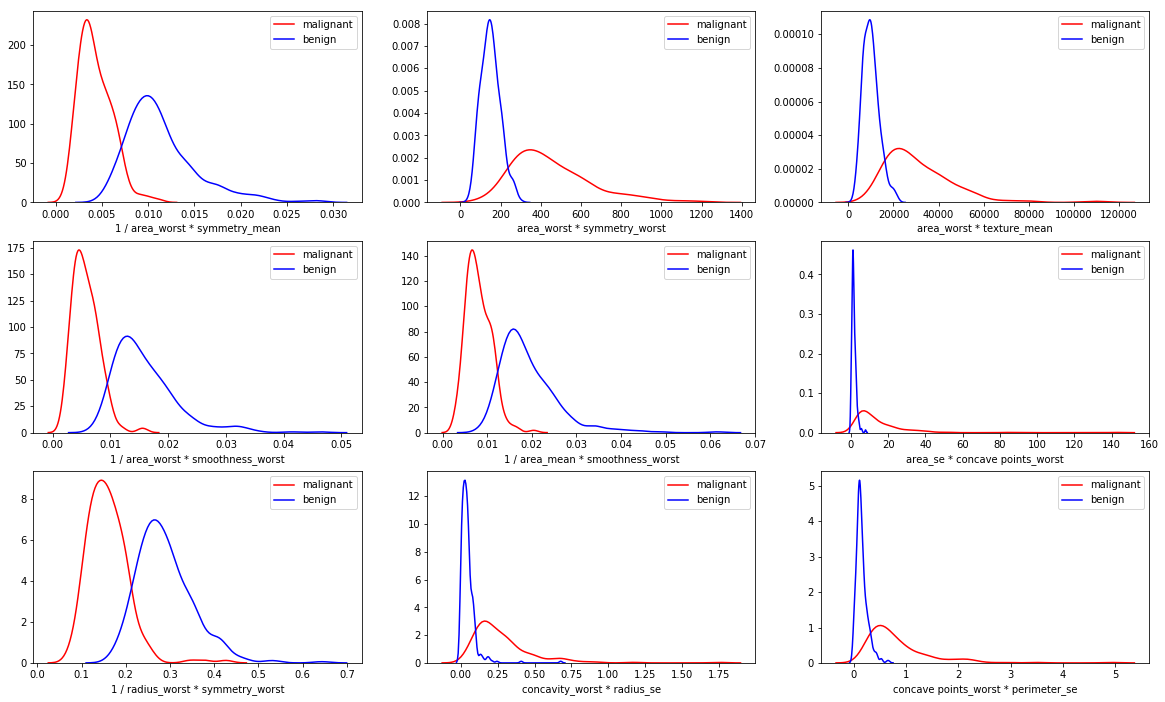

In [163]:
sorted_features = [f[0] for f in d_RF_ft_importances]
plot_feature_top_9(df_feature_matrix_outcomes,sorted_features)

In [31]:
# Prepare input matrix for machine learning models
number_of_features = 10
X_ft_top = df_feature_matrix_outcomes[sorted_features[:10]].values

### Section (5) : Compare the Performance of Machine Leanring Models (with Feature Engineering)
Apply K-fold cross validation to compare the performance after feature engineering with featuretools

#### 1. Add diagnosis column back to the feature matrix

In [22]:
df_outcomes = df_data.loc[:,['id','diagnosis']]
df_outcomes.set_index('id',inplace=True)

df_feature_matrix_outcomes = pd.merge(df_feature_matrix_dropcorr_dropnan,df_outcomes,
                                      left_index=True, right_index=True)
df_feature_matrix_outcomes.head()

,radius_mean,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,...,1 / area_worst * symmetry_mean,1 / fractal_dimension_se * smoothness_mean,1 / area_mean * smoothness_mean,1 / area_se * fractal_dimension_worst,1 / fractal_dimension_worst * perimeter_se,1 / fractal_dimension_se * radius_se,1 / area_se * smoothness_worst,1 / compactness_mean * fractal_dimension_mean,1 / smoothness_worst * symmetry_se,diagnosis
id,,,,,,,,,,,,,,,,,,,,,
8670,15.46,19.48,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,...,0.004480,3721.052075,0.012228,0.258133,4.030505,856.712812,0.133892,141.073411,463.013980,1
8913,12.89,13.12,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,...,0.012963,6909.248063,0.027870,1.140482,12.969790,3136.672342,0.820137,480.502436,642.330725,0
8915,14.96,19.10,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,...,0.006572,3950.620405,0.016181,0.474612,5.436936,1234.757688,0.306238,173.960857,500.403826,0
9047,12.94,16.17,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,...,0.009922,5133.104479,0.019942,1.123668,12.796863,3478.047953,0.751094,182.537712,456.279316,0
85715,13.17,18.66,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0.2871,...,0.006188,2370.458025,0.016153,0.349763,4.471146,956.109506,0.230891,119.868332,321.233743,1


#### 2. Prepare input matrix (after feature engineering) for machine learning models

In [23]:
# Prepare input matrix for machine learning models
feature_names_ft = df_feature_matrix_outcomes.columns.tolist()[1:-1]
X_ft = df_feature_matrix_outcomes[feature_names_ft].values
y_ft = df_feature_matrix_outcomes['diagnosis'].values

#### 3. Apply and compare machine learning models with k-fold cross validation

In [24]:
# Logistic regression
d_Model_eva['Logistic Regression (After Feature Engineering)'] = cross_validatoin(fold, LogisticRegression(), X_ft, y_ft)

# Decision tree
d_Model_eva['Decision Tree (After Feature Engineering)'] = cross_validatoin(fold, DecisionTreeClassifier(), X_ft, y_ft)

# Random forest
d_Model_eva['Random Forest (After Feature Engineering)'] = cross_validatoin(fold, RandomForestClassifier(), X_ft, y_ft)

In [25]:
# Create output dataframe
df_eva = pd.DataFrame(d_Model_eva, index=['Sensitivity','Specificity','Accuracy','F1-score'])
df_eva.round(3).T.sort_values('F1-score',ascending=False)

,Sensitivity,Specificity,Accuracy,F1-score
Random Forest (After Feature Engineering),0.967,0.976,0.970,0.960
Random Forest,0.961,0.957,0.960,0.946
Logistic Regression (After Feature Engineering),0.965,0.946,0.958,0.944
Logistic Regression,0.952,0.949,0.951,0.930
Decision Tree (After Feature Engineering),0.959,0.915,0.940,0.920
Decision Tree,0.939,0.875,0.914,0.880


#### 2. The performance improvement of automated feature engineering

In [27]:
models = ['Logistic Regression','Decision Tree','Random Forest']

for model in models:
    before_fe = df_eva.loc['F1-score',model]
    after_fe = df_eva.loc['F1-score',model+" (After Feature Engineering)"]
    print('{}: Automated feature engineering improves F1-score by {:.3f}'.format(model,after_fe-before_fe))

Logistic Regression: Automated feature engineering improves F1-score by 0.014
Decision Tree: Automated feature engineering improves F1-score by 0.040
Random Forest: Automated feature engineering improves F1-score by 0.013


In [32]:
d_perf_RF = {}

# Random forest - original features
d_perf_RF['Original Features'] = cross_validatoin(fold, RandomForestClassifier(), X, y)

# Random forest - automated feature engineering
d_perf_RF['After Feature Engineering'] = cross_validatoin(fold, RandomForestClassifier(), X_ft, y_ft)

# Random forest - top 10 most important features
d_perf_RF['Top 10 Features'] = cross_validatoin(fold, RandomForestClassifier(), X_ft_top, y_ft)

In [33]:
# Create output dataframe
df_perf_RF = pd.DataFrame(d_perf_RF, index=['Sensitivity','Specificity','Accuracy','F1-score'])
df_perf_RF.round(3).T.sort_values('F1-score',ascending=False)

,Sensitivity,Specificity,Accuracy,F1-score
Top 10 Features,0.956,0.961,0.958,0.941
After Feature Engineering,0.953,0.958,0.956,0.938
Original Features,0.946,0.942,0.944,0.923
